<div align="center">
  <a href="https://optuna.org">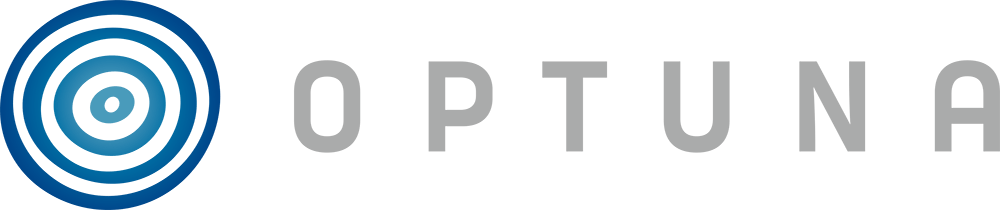</a>
</div>

<h3 align="center">
  <em>An open source hyperparameter optimization framework to automate hyperparameter search</em>
</h3>

# Tutorial on Optuna
In this notebook, we discuss a simple application of Optuna to perform a $\chi^2$ fit. Let $X$ and $Y$ be the input and output datasets respectively, such that $y = \sin(\nu x + \varphi)$ where the parameters $\nu$ and $\varphi$ are to be determinated by the fit procedure. In particular, we will not use any gradient information, and instead we will only exploit our "present knowledge" of the **objective function** ($\chi^2$), namely Bayesian strategies.

Before starting, note that this is a particular challenging minimization process because it has many _local minima_ the optimizer will seek for. A common technique to address this problem is to initialize the minimization multiple times in a **random** way. Here, we will use **Bayesian search** instead of purely random initialization to speed-up _smartly_ the process.

## Let's code!

<table align="left">
  <td>
    <a href="https://github.com/landerlini/mlinfn-advanced-hackathon/blob/main/bayesian_optimization/optuna_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/landerlini/mlinfn-advanced-hackathon/blob/main/bayesian_optimization/optuna_tutorial.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>
  </td>
</table>

## Install and import Optuna
First of all, we need to install Optuna using `pip`.

In [1]:
!pip install optuna > pip.log   # silent 'pip install'

Then, we import several modules that we will use within this notebook (both for analysis and visualization).

In [2]:
import optuna
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from time import sleep

## Data generation and visualization

In [3]:
v_true = 5
phi_true = 4

x_train = np.random.uniform(0, 5, 100)
y_train = np.sin(v_true * x_train + phi_true)

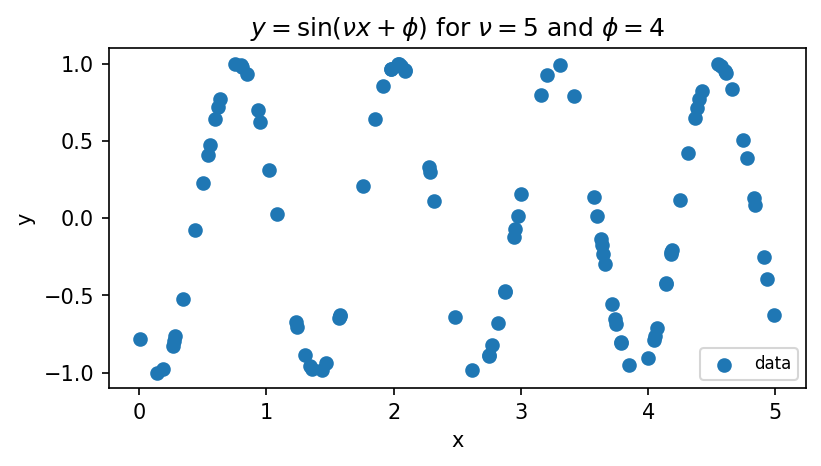

In [4]:
plt.figure(figsize=(6,3), dpi=150)
plt.title(rf"$y = \sin(\nu x + \phi)$ for $\nu={v_true}$ and $\phi={phi_true}$", fontsize=12)
plt.xlabel("x", fontsize=10)
plt.ylabel("y", fontsize=10)
plt.scatter(x_train, y_train, label="data")
plt.legend(loc="lower right", fontsize=8)
plt.show()

## Base Optuna usage
Tha base usage of Optuna only needs two steps:
* defining the **objective function** - python function with a single argument named `trial` that returns the quantity to optimize;
* creating a **study object** - Optuna [`Study`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.Study.html#optuna.study.Study) class that represents our optimization session, namely a set of trials.

### Objective function
Firstly, we define the objective function, a simple Python function that takes only `trial` as argument. Within such function, we can sample parameters (or hyperparameters) to optimize using the Optuna `suggest_*` methods:
* [`optuna.trial.Trial.suggest_categorical()`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial.suggest_categorical) for categorical parameters;
* [`optuna.trial.Trial.suggest_int()`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial.suggest_int) for integer parameters;
* [`optuna.trial.Trial.suggest_float()`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial.suggest_float) for floating point parameters.

The `suggest_*` methods also define the **search space**. Moreover, with the optional arguments `step` and `log`, we can discretize or take the logarithm of integer and floating point parameters.

In this case, we are interested in finding the best combination of $\nu$ and $\varphi$ that minimizes $\chi^2$, our objective function. We choose to look for $\nu_\text{best} \in (0, 10)$ and $\varphi_\text{best} \in (-10, 10)$, our search spaces.

Note that $\chi^2$ is implemented in TensorFlow just to demonstrate that this framework is suitable for _any_ Machine Learning application.

In [5]:
def chi_square(trial):
  v = trial.suggest_float("v", 0, 10)
  phi = trial.suggest_float("phi", -10, 10)
  y = tf.sin(v * x_train + phi)
  sleep(0.5)   # just to ease visualization
  return tf.reduce_mean(tf.square(y - y_train))

### Optuna Study
To run optimization campaign we need a [`Study`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.Study.html#optuna.study.Study) instance to store, manage and manipulate [`Trial`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial) objects. We can create a `Study` object using the [`create_study()`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.create_study.html) method that has several arguments. For the moment, we will explore just a couple of these arguments:
* `study_name` - Study's name;
* `sampler` - A sampler object implementing the algorithm for value suggestion;
* `direction` - Direction of optimization, namely `"minimize"` or `"maximize"`.

In this case, we adopt a Tree-structured Parzen Estimator (TPE) as **surrogate model** and an Expected Improvement (EI) as **acquisition function** through the [`optuna.samplers.TPESampler`](https://optuna.readthedocs.io/en/stable/reference/samplers/generated/optuna.samplers.TPESampler.html) class. Moreover, we are obviously interested in finding the best combination of $\nu$ and $\phi$ that minimizes the $\chi^2$.

<details markdown="1">
<summary><b>Resume saved Study</b></summary>

To resume a study, instantiate a `Study` object passing the study name `"example-study"` and the DB URL `"sqlite:///example-study.db"` (passed to the `storage` argument):

```python
study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True)
```

Or directly load an existing `Study` object:
```python
loaded_study = optuna.load_study(study_name=study_name, storage=storage_name)
```
</details>

In [6]:
study = optuna.create_study(
    study_name="tutorial_optuna_sin_base",
    sampler=optuna.samplers.TPESampler(),
    direction="minimize"
)

[I 2022-11-23 21:55:39,349] A new study created in memory with name: tutorial_optuna_sin_base


### Let's optimize!
After having instantiated a `Study` object, running an optimization campaign simply needs to call the [`optimize()`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.Study.html#optuna.study.Study.optimize) method.

In [7]:
study.optimize(chi_square, n_trials=50)

[I 2022-11-23 21:55:39,917] Trial 0 finished with value: 1.1045561204862357 and parameters: {'v': 1.988685707705009, 'phi': -4.065018260549785}. Best is trial 0 with value: 1.1045561204862357.
[I 2022-11-23 21:55:40,422] Trial 1 finished with value: 0.8722499919061272 and parameters: {'v': 0.48692328314207667, 'phi': -1.028749014607655}. Best is trial 1 with value: 0.8722499919061272.
[I 2022-11-23 21:55:40,927] Trial 2 finished with value: 0.6267635178025244 and parameters: {'v': 0.17246418486663084, 'phi': -9.616658643239584}. Best is trial 2 with value: 0.6267635178025244.
[I 2022-11-23 21:55:41,433] Trial 3 finished with value: 1.4643830316045114 and parameters: {'v': 5.748699867207407, 'phi': 5.064879276681287}. Best is trial 2 with value: 0.6267635178025244.
[I 2022-11-23 21:55:41,938] Trial 4 finished with value: 1.0496866426283507 and parameters: {'v': 0.9129047561896853, 'phi': -5.938853824589405}. Best is trial 2 with value: 0.6267635178025244.
[I 2022-11-23 21:55:42,443] Tri

The whole information stored in the Study object can be accessed through a Pandas DataFrame using the `Study` [`trials_dataframe()`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.Study.html#optuna.study.Study.trials_dataframe) method.

In [8]:
df = study.trials_dataframe()
df.sort_values(by="value", ascending=True)[:10]

,number,value,datetime_start,datetime_complete,duration,params_phi,params_v,state
31,31,0.279923,2022-11-23 21:55:55.686829,2022-11-23 21:55:56.200279,0 days 00:00:00.513450,9.843390,5.365723,COMPLETE
41,41,0.304470,2022-11-23 21:56:00.980218,2022-11-23 21:56:01.493902,0 days 00:00:00.513684,9.056550,5.529044,COMPLETE
11,11,0.386805,2022-11-23 21:55:45.004553,2022-11-23 21:55:45.571860,0 days 00:00:00.567307,-9.577070,5.552019,COMPLETE
20,20,0.576863,2022-11-23 21:55:49.841351,2022-11-23 21:55:50.379076,0 days 00:00:00.537725,8.348142,5.795516,COMPLETE
19,19,0.585999,2022-11-23 21:55:49.318559,2022-11-23 21:55:49.837795,0 days 00:00:00.519236,9.789354,5.553476,COMPLETE
21,21,0.587240,2022-11-23 21:55:50.387230,2022-11-23 21:55:50.901225,0 days 00:00:00.513995,9.193176,5.698883,COMPLETE
2,2,0.626764,2022-11-23 21:55:40.424037,2022-11-23 21:55:40.927597,0 days 00:00:00.503560,-9.616659,0.172464,COMPLETE
39,39,0.700934,2022-11-23 21:55:59.953615,2022-11-23 21:56:00.464228,0 days 00:00:00.510613,-4.279330,5.286687,COMPLETE
18,18,0.716223,2022-11-23 21:55:48.778235,2022-11-23 21:55:49.315027,0 days 00:00:00.536792,-5.952176,2.994660,COMPLETE
26,26,0.716720,2022-11-23 21:55:53.030180,2022-11-23 21:55:53.555218,0 days 00:00:00.525038,2.765404,4.975587,COMPLETE


Recovering the best parameters is straightforward:

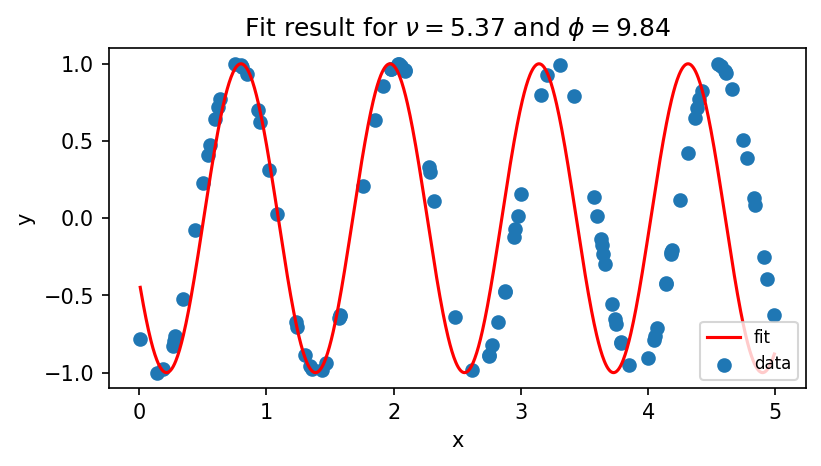

In [9]:
v_best = study.best_params["v"]
phi_best = study.best_params["phi"]

x_model = np.linspace(x_train.min(), x_train.max(), 1000)
y_model = np.sin(v_best * x_model + phi_best)

plt.figure(figsize=(6,3), dpi=150)
plt.title(rf"Fit result for $\nu = {v_best:.2f}$ and $\phi = {phi_best:.2f}$", fontsize=12)
plt.xlabel("x", fontsize=10)
plt.ylabel("y", fontsize=10)
plt.scatter(x_train, y_train, label="data")
plt.plot(x_model, y_model, color="r", label="fit")
plt.legend(loc="lower right", fontsize=8)
plt.show()

### Visualizing optimization campaigns
Optuna provides various visualization features in [`optuna.visualization`](https://optuna.readthedocs.io/en/stable/reference/visualization/index.html#module-optuna.visualization) to analyze optimization results visually. In this tutorial, we present only `plot_contour` and `plot_optimization_history`, while further functions can be found [here](https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html).

In [10]:
from optuna.visualization import plot_contour
from optuna.visualization import plot_optimization_history

In [11]:
plot_optimization_history(study)

In [12]:
plot_contour(study)

## Fast Optuna usage
In a typical Machine Learning application, chosen a set of hyperparameters, the objective function is evaluated _multiple times_ during the training ($N_\text{batch}$ times per epoch, $N_\text{epochs}$ times per training). The general idea to **speed up** the optimization study is to discard not promising hyperparameter trials before to complete the training procedure in order to save time. This can be done using the [`pruners`](https://optuna.readthedocs.io/en/stable/reference/pruners.html) module that provides several strategies for deciding when to keep till the end a set of hyperparameters or when to discard them.

In [13]:
study_fast = optuna.create_study(
    study_name="tutorial_optuna_sin_fast",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.MedianPruner(),
    direction="minimize"
)

[I 2022-11-23 21:56:06,260] A new study created in memory with name: tutorial_optuna_sin_fast


### Ask-and-Tell interface
To enable the speed-up provided by the pruning strategies, we need to re-implement the optimization campaing using Optuna at _low-level_, and in particular relying on the **Ask-and-Tell** interface. In this configuration, we do not need anymore the definition of an objective function and of calling the `optimize()` method, since the optimization campaign is implemented _explicitly_. 

After having defined the search space using the `suggest_*` methods, we can sample trial values asking for them through the `Study` [`ask()`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.Study.html#optuna.study.Study.ask) method, typically within a loop. Using such hyperparameters we can compute the objective function and update the study database telling the result obtained through the `Study` [`tell()`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.Study.html#optuna.study.Study.tell) method, again within a loop.

Once we have set up an Ask-and-Tell system, we are ready to implement the pruning strategy passing intermediate values of the objective function through the `Trial` [`report()`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial.report) method. The latter enables the [`should_prune()`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial.should_prune) boolean flag that can be used for **early stopping**.

Implementing the Ask-and-Tell interface in our use-case, we will perform an optimization study slightly different to what done with the base version of Optuna. In particular, we will use Bayesian strategies to _initialize_ the parameters $\nu$ and $\varphi$, that are then updated using **gradient-based information** through SGD techniques (i.e. Adam).

In [14]:
v_tf = tf.Variable(5.0)
phi_tf = tf.Variable(4.0)

vars = phi_tf, v_tf

def chi_square_fast():   # this is NOT the Optuna objective function
  y = tf.sin(v_tf * x_train + phi_tf)
  return tf.reduce_mean(tf.square(y - y_train))

In [15]:
def my_study_optimization(study, n_trials=15, n_steps=15, verbose=False):
  """
  Custom optimization function with ask-and-tell interface
  """
  local_trials = list()

  optimizer = tf.keras.optimizers.Adam(0.02)

  for iTrial in range(n_trials):
    trial = study.ask()
    pruned_trial = False

    v = trial.suggest_float("v", 0, 10)
    phi = trial.suggest_float("phi", -10, 10)
    if verbose: print(f"Trial n.{trial.number:02} - v: {v:.3f}, phi: {phi:.3f}")

    v_tf.assign(v)
    phi_tf.assign(phi)

    for iStep in range(n_steps):
      with tf.GradientTape() as tape:
        loss = chi_square_fast()
        grads = tape.gradient(loss, vars)
        optimizer.apply_gradients(zip(grads, vars))

      trial.report(loss, iStep)

      if verbose and ((iStep+1) % 5) == 0:
        print(f".. Step n.{iStep:02} - loss: {loss:.3f} - v: {v_tf.numpy():.3f}, phi: {phi_tf.numpy():.3f}")

      if trial.should_prune():
        pruned_trial = True
        break

    if pruned_trial:
      study.tell(trial, state=optuna.trial.TrialState.PRUNED)   # tell the pruned state
      status = "PRUNED"
      if verbose: print(".. TRIAL PRUNED")
    else:
      study.tell(trial, loss)   # tell objective function
      status = "COMPLETE"
      if verbose: print(".. TRIAL COMPLETE")

    local_trials.append([trial.number, float(loss), float(v_tf.numpy()), float(phi_tf.numpy()), status])

  return pd.DataFrame(local_trials, columns=["number", "loss", "v", "phi", "status"])

In [16]:
df_1 = my_study_optimization(study_fast, verbose=True)

Trial n.00 - v: 8.539, phi: -9.883
.. Step n.04 - loss: 0.949 - v: 8.440, phi: -9.983
.. Step n.09 - loss: 0.920 - v: 8.343, phi: -10.081
.. Step n.14 - loss: 0.892 - v: 8.247, phi: -10.178
.. TRIAL COMPLETE
Trial n.01 - v: 2.478, phi: 2.889
.. Step n.04 - loss: 0.808 - v: 2.377, phi: 2.784
.. Step n.09 - loss: 0.799 - v: 2.295, phi: 2.692
.. Step n.14 - loss: 0.807 - v: 2.273, phi: 2.646
.. TRIAL COMPLETE
Trial n.02 - v: 3.609, phi: 7.470
.. Step n.04 - loss: 1.109 - v: 3.673, phi: 7.468
.. Step n.09 - loss: 1.023 - v: 3.782, phi: 7.496
.. Step n.14 - loss: 0.943 - v: 3.903, phi: 7.515
.. TRIAL COMPLETE
Trial n.03 - v: 5.568, phi: -1.041
.. Step n.04 - loss: 1.524 - v: 5.649, phi: -1.128
.. Step n.09 - loss: 1.477 - v: 5.703, phi: -1.259
.. Step n.14 - loss: 1.426 - v: 5.750, phi: -1.401
.. TRIAL COMPLETE
Trial n.04 - v: 7.346, phi: 4.495
.. Step n.04 - loss: 0.981 - v: 7.405, phi: 4.386
.. Step n.09 - loss: 0.961 - v: 7.471, phi: 4.314
.. Step n.14 - loss: 0.950 - v: 7.526, phi: 4.25

In [17]:
df_1.sort_values(by="loss", ascending=True)[:10]

,number,loss,v,phi,status
11,11,0.532436,0.075968,2.787045,COMPLETE
1,1,0.807017,2.272530,2.646091,COMPLETE
9,9,0.809314,2.130427,3.385334,COMPLETE
14,14,0.830100,1.027461,-4.224123,COMPLETE
7,7,0.832102,2.245743,-2.727409,COMPLETE
0,0,0.892334,8.247360,-10.178347,COMPLETE
2,2,0.942799,3.902694,7.515057,COMPLETE
4,4,0.950032,7.526166,4.255093,COMPLETE
13,13,1.009611,3.639894,9.853395,PRUNED
5,5,1.052342,1.961583,2.628319,PRUNED


In [18]:
df_2 = my_study_optimization(study_fast, n_trials=40)   # add 10 more to the study

In [19]:
plot_optimization_history(study_fast)

In [20]:
df = pd.concat([df_1, df_2], ignore_index=True)
df.sort_values(by="loss")[:10]

,number,loss,v,phi,status
45,45,0.001059,4.983084,4.068613,COMPLETE
44,44,0.050324,4.785312,4.629130,COMPLETE
23,23,0.082749,4.782791,4.509077,COMPLETE
16,16,0.169947,4.632588,5.231791,COMPLETE
32,32,0.229369,5.453967,8.898435,COMPLETE
31,31,0.244777,5.467821,8.768466,COMPLETE
52,52,0.263615,5.493328,2.527242,COMPLETE
27,27,0.374013,5.609344,8.471634,COMPLETE
22,22,0.376358,4.412659,5.653677,COMPLETE
11,11,0.532436,0.075968,2.787045,COMPLETE


### Results visualization

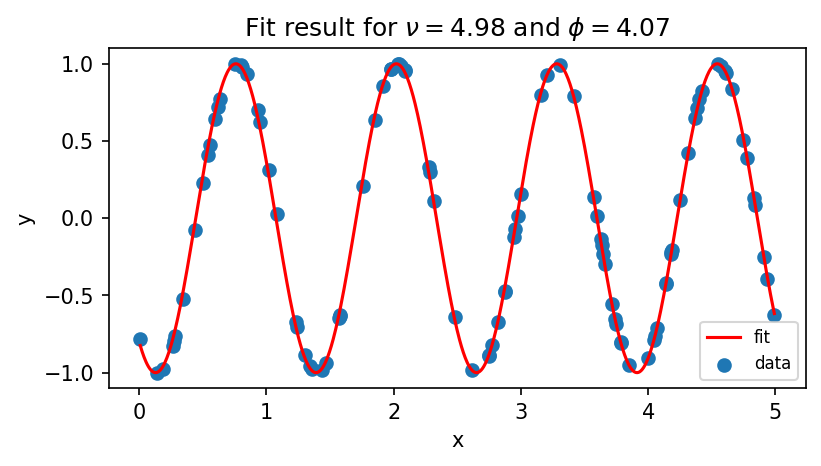

In [21]:
v_best = df["v"].iloc[df["loss"].argmin()]
phi_best = df["phi"].iloc[df["loss"].argmin()]

x_model = np.linspace(x_train.min(), x_train.max(), 1000)
y_model = np.sin(v_best * x_model + phi_best)

plt.figure(figsize=(6,3), dpi=150)
plt.title(rf"Fit result for $\nu = {v_best:.2f}$ and $\phi = {phi_best:.2f}$", fontsize=12)
plt.xlabel("x", fontsize=10)
plt.ylabel("y", fontsize=10)
plt.scatter(x_train, y_train, label="data")
plt.plot(x_model, y_model, color="r", label="fit")
plt.legend(loc="lower right", fontsize=8)
plt.show()